In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import time

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform=transform)


Extracting ../Data/cifar-10-python.tar.gz to ../Data


In [4]:
test_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [5]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [9]:
class_names = ['plane', ' car', ' bird', ' cat', ' deer', ' dog', ' frog', ' horse', ' ship', ' truck']

In [10]:
for images, labels in train_loader:
    break

In [11]:
labels

tensor([9, 5, 2, 3, 0, 5, 9, 5, 1, 6])

Label:  [9 5 2 3 0 5 9 5 1 6]
Class:   truck  dog  bird  cat plane  dog  truck  dog  car  frog


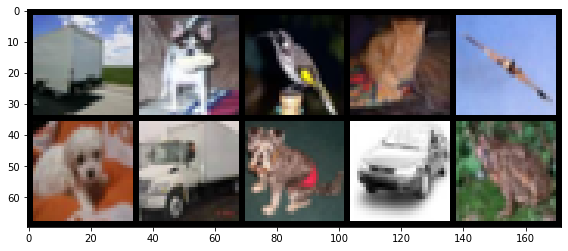

In [13]:
print('Label: ', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)
plt.figure(figsize=(10, 4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [16]:
class ConvolutionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6 * 6 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6 * 6 * 16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.log_softmax(self.fc3(X), dim=1)
        return X

In [17]:
torch.manual_seed(101)
model = ConvolutionNetwork()
model

ConvolutionNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [18]:
for param in model.parameters():
    print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (b % 1000) == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10 * b:6} / 50000]  loss: {loss.item():10.8f}  accuracy: {trn_corr.item() * 100/(10 * b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)

            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:  0  batch: 1000 [ 10000 / 50000]  loss: 2.22860122  accuracy:  24.980%
epoch:  0  batch: 2000 [ 20000 / 50000]  loss: 1.54422069  accuracy:  31.705%
epoch:  0  batch: 3000 [ 30000 / 50000]  loss: 0.99153328  accuracy:  35.193%
epoch:  0  batch: 4000 [ 40000 / 50000]  loss: 1.13128543  accuracy:  37.523%
epoch:  0  batch: 5000 [ 50000 / 50000]  loss: 1.72510743  accuracy:  39.170%
epoch:  1  batch: 1000 [ 10000 / 50000]  loss: 1.44353020  accuracy:  47.180%
epoch:  1  batch: 2000 [ 20000 / 50000]  loss: 1.37904251  accuracy:  48.640%
epoch:  1  batch: 3000 [ 30000 / 50000]  loss: 1.27034760  accuracy:  49.533%
epoch:  1  batch: 4000 [ 40000 / 50000]  loss: 1.59789824  accuracy:  50.470%
epoch:  1  batch: 5000 [ 50000 / 50000]  loss: 1.42439675  accuracy:  50.986%
epoch:  2  batch: 1000 [ 10000 / 50000]  loss: 1.16908026  accuracy:  56.210%
epoch:  2  batch: 2000 [ 20000 / 50000]  loss: 1.46088922  accuracy:  56.180%
epoch:  2  batch: 3000 [ 30000 / 50000]  loss: 1.52235270  accur

In [21]:
torch.save(model.state_dict(), './myCIFARmodel.pt')

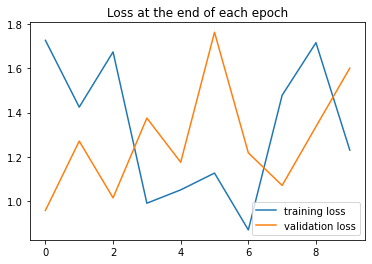

In [23]:
with torch.no_grad():
    plt.plot(train_losses, label='training loss')
    plt.plot(test_losses, label='validation loss')
    plt.title('Loss at the end of each epoch')
    plt.legend()

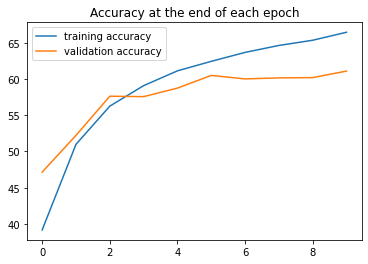

In [24]:
plt.plot([t / 500 for t in train_correct], label='training accuracy')
plt.plot([t / 100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [25]:
print(test_correct)

[tensor(4716), tensor(5222), tensor(5763), tensor(5757), tensor(5875), tensor(6050), tensor(6002), tensor(6016), tensor(6020), tensor(6110)]


In [27]:
num_c = test_correct[-1].item()

In [29]:
num_c * 100 / 10000

61.1

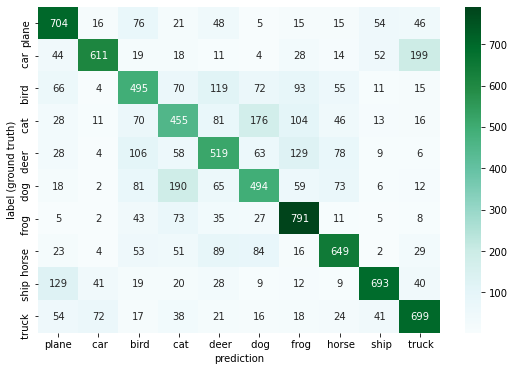

In [31]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize=(9, 6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()